# Intoduction

This notebook represents my first participation to a Kaggle competition.

My goal is following:
1. Explore the data to gain insights
2. Feature engineering based on the insights
3. Impute missing values
5. Preprocessing
6. Training Machine Learning methods
7. Make the predicition

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier

# Data description

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

Data shape

In [4]:
print(f'Shape of train data: {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Shape of test data: {test.shape[0]} rows and {test.shape[1]} columns') 
train.head()

Shape of train data: 8693 rows and 14 columns
Shape of test data: 4277 rows and 13 columns


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Records of each passenger

In [5]:
print('passengers in train:', train.PassengerId.nunique())
print('passengers in test:', test.PassengerId.nunique())

passengers in train: 8693
passengers in test: 4277


The passenger number equals to the data rows in each dataset, which means one passenger one record.

### Feature descriptions:

- PassengerId : A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet : The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin : The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination : The planet the passenger will be debarking to.
- Age : The age of the passenger.
- VIP : Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck : Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name : The first and last names of the passenger.

- Transported : Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# EDA

### Target distribution
Explore the target to see whether under/over-sampling is needed

Text(0.5, 1.0, 'Target Distribution')

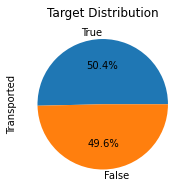

In [6]:
# set the figure size
plt.figure(figsize = (3,3))


# since our target, 'Transported', is categorical, using pie chart to show the percentage of each type
train.Transported.value_counts().plot.pie(autopct = '%1.1f%%').set_title('Target Distribution')

The target is balanced, so we dont need the under/over-sampling.

### Continuous features

In [7]:
# list feature types
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
# get the continuous features
train.select_dtypes('float64').columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

### Age

Visualize the 'Age' distribution togerther with 'Transported' to get insights

Text(0.5, 1.0, 'Age distribution')

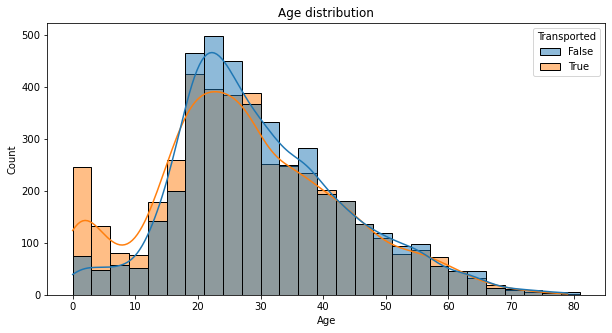

In [9]:
# set the figure size
plt.figure(figsize = (10,5))

sns.histplot(data = train, x = 'Age', hue = 'Transported', binwidth=3, kde=True)

plt.title('Age distribution')

The KDE plot shows the probability of getting transported or not at each age.

So we can find:
- 0~18 years old have **higher** chance to be transported.
- 18~40 years old have **lower** chance to be transported.
- over 40 years old are **equal** like to be transported.

Insights:
- create a new feature represents the category of age by 0~18, 18~40, >40

### Expenditure features

In [10]:
expenditure_features = train.select_dtypes('float64').columns.drop('Age')
expenditure_features

Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

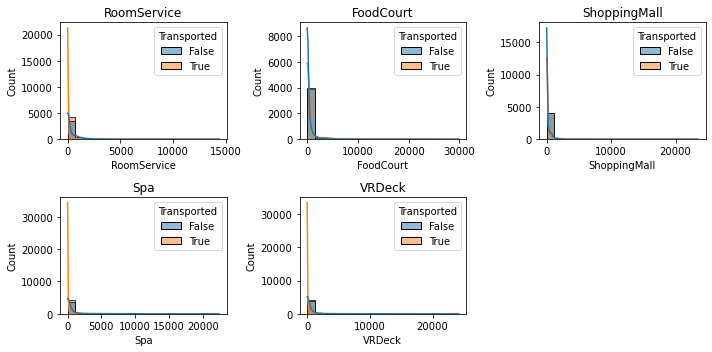

In [11]:
# visualize the expenditure features with hitogram and show them at once

fig = plt.figure(figsize=(10,5))

for idx, val in enumerate(expenditure_features):
    ax = fig.add_subplot(2,3,idx+1)
    sns.histplot(data=train, x=val, axes=ax, bins=20 ,hue='Transported', kde=True)
    ax.set_title(val)
    
plt.tight_layout()  
plt.show()

Since the data is uneven(most of passenger don't spend money), let's limit the y axis to make it more clear.

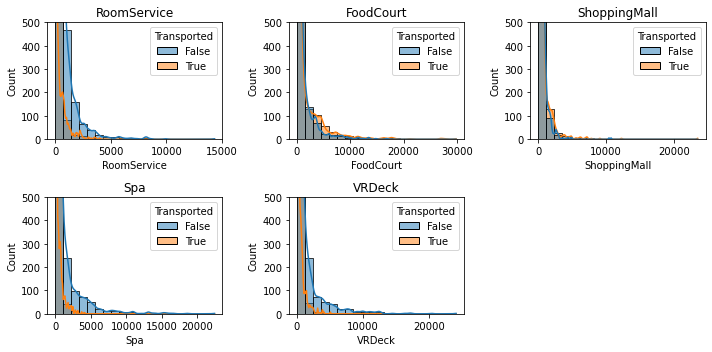

In [12]:
# visualize the expenditure features with hitogram and show them at once

fig = plt.figure(figsize=(10,5))

for idx, val in enumerate(expenditure_features):
    ax = fig.add_subplot(2,3,idx+1)
    sns.histplot(data=train, x=val, axes=ax, bins=20 ,hue='Transported', kde=True)
    ax.set_title(val)
    
    plt.ylim([0,500])
    
plt.tight_layout()  
plt.show()

We can find:
- Most passengers don't spend money
- There are smaller number of outliers
- Passengers who are transported tend to spend less(orange line is lower than blue line)
- The KDE plot of 'FoodCout' and 'ShoppingMall' is different with others

Insights:
- Create new feature which represent passenger spend money or not.
- Create new feature which represent the total spent of each passenger.
- Create new feature which consider 'FoodCout' and 'ShoppingMall' as one group, and group the rest expenditure features.
- The features distribute skewly, we may used log transformation to make it become normal distribution.

### Categorical features

In [13]:
categorical_features = train.select_dtypes('object').columns.drop(['PassengerId', 'Name', 'Cabin'])
categorical_features

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], dtype='object')

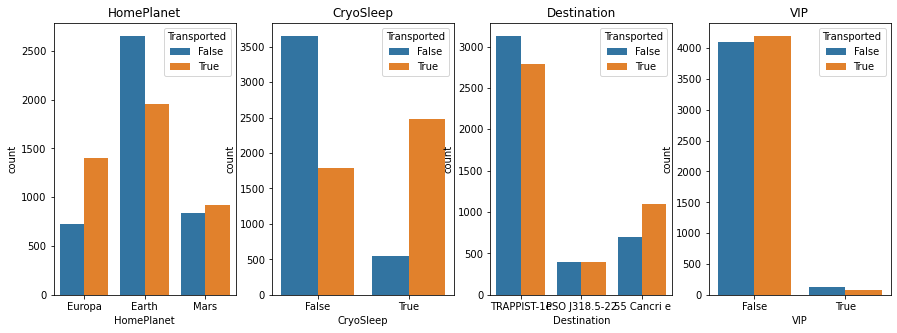

In [14]:
# visualize the observation number of each categorical features by count chart

# set the figure size
fig = plt.figure(figsize=(15,5))

for idx, val in enumerate(categorical_features):
    ax = fig.add_subplot(1,4,idx+1)
    sns.countplot(data=train, x=val, axes=ax, hue='Transported')
    ax.set_title(val)
    
plt.show()

We can find:
- The state of feature,'CryoSleep', shows obvious difference in Transported.
- 'VIP' does not provide useful information.


Insights:
- The feature 'VIP' could be droppred


### Qualitative features

In [15]:
qualitative_features = train[['PassengerId','Cabin','Name']]

qualitative_features.head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


We can find:
- first 4 number in 'PassengerId' is the group number, we may extract this number out as a new feature.
- the information in 'Cabin' cae be extracted out


Insights:
- We can create new feature that indicates the group number
- We can create new feature that indicates the group size
- We can create new features that represented deck, num ,side


## Check missing values

In [16]:
# create a function for showing the percentage of missing values in each feature
def show_missing_value_percentage(df):
   total = df.isnull().sum().sort_values(ascending=False)
   percentage = (df.isnull().sum() / df.count()).sort_values(ascending=False) * 100
   percentage_str = percentage.map('{:.2f}%'.format)
   missing_data = pd.concat([total, percentage_str], axis = 1, keys=['Total', 'Percentage'])
   missing_data = missing_data[total > 0]
   
   return missing_data 

In [17]:
show_missing_value_percentage(train)

,Total,Percentage
CryoSleep,217,2.56%
ShoppingMall,208,2.45%
VIP,203,2.39%
HomePlanet,201,2.37%
Name,200,2.35%
Cabin,199,2.34%
VRDeck,188,2.21%
FoodCourt,183,2.15%
Spa,183,2.15%
Destination,182,2.14%


In [18]:
show_missing_value_percentage(test)

,Total,Percentage
FoodCourt,106,2.54%
Spa,101,2.42%
Cabin,100,2.39%
ShoppingMall,98,2.35%
Name,94,2.25%
CryoSleep,93,2.22%
VIP,93,2.22%
Destination,92,2.20%
Age,91,2.17%
HomePlanet,87,2.08%


 - No missing values in 'Transported', which is our target
 - The percentage of missing vlaues in each features is less than 3%, which is few.

### Calculate how many rows contains missing value

In [19]:
print('percentage of rows contain missing values : {:.2%}'.format(1 - (len(train.dropna())/len(train))))

percentage of rows contain missing values : 24.01%


- We will lost nearly 1/4 data if we drop the observation which contains missing value.
- So we have to impute missing values with the insights from EDA

### Initial imputation before feature engineering

In [20]:
# create copy for avoiding to change the orginal table
train_copy = train.copy()
test_copy = test.copy()

Impute the mean value of 'Age'

Aim: to be able to create age categories

In [21]:
# new a imputer
age_imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
# imputation
train_copy[['Age']] = age_imputer.fit_transform(train_copy[['Age']])
test_copy[['Age']] = age_imputer.fit_transform(test_copy[['Age']])

In [22]:
print('missing values of "Age" in training data:',len(train_copy[train_copy['Age'].isna()]))
print('missing values of "Age" in testing data:',len(test_copy[test_copy['Age'].isna()]))

missing values of "Age" in training data: 0
missing values of "Age" in testing data: 0


Impute 'Cabin' for 'Z/9999/Z'

Aim: to be able to split the 'Cabin' column into deck, num, side

In [23]:
# new a imputer
cabin_imputer = SimpleImputer(strategy='constant', fill_value='Z/9999/Z')
# imputation
train_copy[['Cabin']] = cabin_imputer.fit_transform(train_copy[['Cabin']])
test_copy[['Cabin']] = cabin_imputer.fit_transform(test_copy[['Cabin']])

In [24]:
print('missing values of "Cabin" in training data:',len(train_copy[train_copy['Cabin'].isna()]))
print('missing values of "Cabin" in testing data:',len(test_copy[test_copy['Cabin'].isna()]))

missing values of "Cabin" in training data: 0
missing values of "Cabin" in testing data: 0


## Feature Engineering

- In this section, new features are going to be created as functions based on the insights .

- These functions will make us easier to apply the same processing on different tables.



### Age

In [25]:
def create_age_category(df):
    
    df['age_category'] = np.where(
                                df['Age'] <= 18, 'child', np.where(
                                df['Age'] <= 40, 'young_adult', 'adult'
        )
    )
    return df

def create_age_subcategory(df) :
    
    df["AgeSubcategory"] = np.where(
                                df["Age"] <= 2, "Baby", np.where(
                                df["Age"] <= 10, "Kid", np.where(
                                df["Age"] <= 19, "Teenager", np.where(
                                df["Age"] <= 29, "twenties", np.where(
                                df["Age"] <= 39, "Thirties", np.where(
                                df["Age"] <= 49, "Forties",                                                         
                                    "Mature"))))))
    
    return df    

### Expenditure features

In this section, we are goin to do:
- Create new feature which represent the total spent of each passenger.
- Create new feature which represent passenger spend money or not.
- Create new feature which consider 'FoodCout' and 'ShoppingMall' as one group, and group the rest expenditure features(luxury expenditure).

Feature: Total expenses 

In [26]:
def create_total_expenses(df):
    
    df['total_expenses'] = df[expenditure_features].sum(axis=1)
    
    return df

Feature: have_expenses

In [27]:
def create_have_expenses(df):
    
    df['have_expenses'] = (df['total_expenses'] == 0).astype(bool)
    df['have_expenses'] = (df['total_expenses'] != 0).astype(bool)
    
    return df

Feature: expenses_group

In [28]:
def create_expenses_group(df):
    
      
    df['normal_expenses'] = df['FoodCourt'] + df['ShoppingMall']
    df['luxury_expenses'] = df['RoomService'] + df['Spa'] + df['VRDeck']
    
    
    
    return df

### Qualitative Features

Feature: group number of each passenger belongs to

In [29]:
def create_passenger_group_number(df):
    
    df['passenger_group_number'] = df['PassengerId'].apply(lambda x : x.split('_')[0])
    
    return df

Feature : cabin information - deck, num, side

In [30]:
def create_cabin_feature(df):
        
    df['Cabin_deck'] = df['Cabin'].apply(lambda x : x.split('/')[0])
    df['Cabin_num'] = df['Cabin'].apply(lambda x : x.split('/')[1])
    df['Cabin_side'] = df['Cabin'].apply(lambda x : x.split('/')[2])
    
    # drop the 'Cabin' since the information is extraced out
    df.drop('Cabin', axis = 1)
    
    return df

### Create the new feature pipeline

Since both the training and testing set are going to be transformed in the same manner, the FunctionTransformer is a tool to do this job efficiently.

In [31]:
age_transformer= FunctionTransformer(create_age_category)
age_subcat_transformer = FunctionTransformer(create_age_subcategory)
total_expenses_transformer = FunctionTransformer(create_total_expenses)
have_expenses_transformer = FunctionTransformer(create_have_expenses)
expenses_group_transformer = FunctionTransformer(create_expenses_group)
passenger_group_number_transformer = FunctionTransformer(create_passenger_group_number)
cabin_transformer = FunctionTransformer(create_cabin_feature)

In [32]:
feature_engineering = make_pipeline(
    age_transformer,
    age_subcat_transformer,
    total_expenses_transformer,
    have_expenses_transformer,
    expenses_group_transformer,
    passenger_group_number_transformer,
    cabin_transformer
)

In [33]:
train_new_features = feature_engineering.transform(train_copy)
test_new_features = feature_engineering.transform(test_copy)

Text(0.5, 1.0, 'Transported based on age_category')

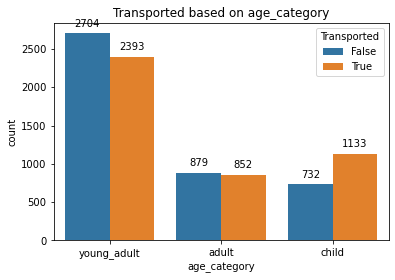

In [34]:
splot = sns.countplot(data=train_new_features, x='age_category', hue='Transported')

for p in splot.patches:
    splot.annotate(format(p.get_height(), ".0f"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = "center", va = "center", xytext = (0, 10), textcoords = "offset points")
plt.title('Transported based on age_category')

## Dealing with missing value

Procedures:
1. CryoSleep X Expense
2. Passenger Group X HomePlanet
3. Cabin X HomePlanet
4. Expenditure features X Age
5. VIP X Age

### Expense X CryoSleep

motivation:
can the passengers in CryoSleep spend money?

<AxesSubplot:xlabel='have_expenses', ylabel='CryoSleep'>

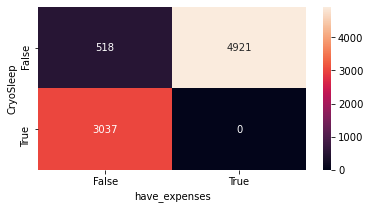

In [35]:
df_cryo_expenses = train_new_features.groupby(['CryoSleep','have_expenses'])['have_expenses'].size().unstack().fillna(0)
df_cryo_expenses

plt.figure(figsize=(6,3))
sns.heatmap(df_cryo_expenses, annot=True, fmt='g')

What we learn:
1. Passengers in CryoSleep CANNOT spend money
2. Most passengers who are not in CryoSleep DO spend money

Upcoming step:
1. Impute 'CryoSleep' = False if have_expenses = True
2. Impute 0 to all expenditure features if 'CryoSleep' = True

In [36]:
# Impute 'CryoSleep' = False if have_expenses = True
def impute_cryosleep_false_if_haveexpenses_true(df):
    
    df.loc[df['have_expenses'] == True, 'CryoSleep'] = False
    
    return df

In [37]:
# Impute 0 to all expenditure features if 'CryoSleep' = True
def impute_0_to_expenditure_if_cryosleep_true(df, expenditure_features):
    
    df.loc[df['CryoSleep'] == True, 'total_expenses'] = 0
    for col in expenditure_features:
        df.loc[df['CryoSleep'] == True, col] = 0
    
    return df

In [38]:
# show number of missing values BEFORE imputation
print("Train: Missing values in CryoSleep: ", train_new_features["CryoSleep"].isnull().sum())
print("Test: Missing values in CryoSleep: ", test_new_features["CryoSleep"].isnull().sum())

Train: Missing values in CryoSleep:  217
Test: Missing values in CryoSleep:  93


In [39]:
train_new_features = impute_cryosleep_false_if_haveexpenses_true(train_new_features)
train_new_features = impute_0_to_expenditure_if_cryosleep_true(train_new_features,expenditure_features)

test_new_features = impute_cryosleep_false_if_haveexpenses_true(test_new_features)
test_new_features = impute_0_to_expenditure_if_cryosleep_true(test_new_features,expenditure_features)

In [40]:
# show number of missing values AFTER imputation
print("Train: Missing values in CryoSleep: ", train_new_features["CryoSleep"].isnull().sum())
print("Test: Missing values in CryoSleep: ", test_new_features["CryoSleep"].isnull().sum())

Train: Missing values in CryoSleep:  98
Test: Missing values in CryoSleep:  38


### Passenger Group X HomePlanet

motivation: do passengers in the same group come from the same HomePlanet?

In [41]:
df_uni_homeplanet = train_new_features.groupby(['passenger_group_number'])['HomePlanet'].nunique().reset_index().rename(columns={'HomePlanet' : 'uni_homeplanet'})
print('Group numbers with different HomePlanet:', len(df_uni_homeplanet[df_uni_homeplanet['uni_homeplanet'] > 1]))

Group numbers with different HomePlanet: 0


What we learned:
- So the passengers in the same group come from the same HomePlanet

Upcoming step:
- If 'HomePlanet' is missing, impute it with the HomePlanet of the other passenger within the same group

In [42]:
def impute_HomePlanet_based_on_group(df):
    
    mode_dict = df.groupby(['passenger_group_number'])['HomePlanet'].agg(pd.Series.mode).to_dict()
    
    new_dict = {key: value for key, value in mode_dict.items() if type(value) == str}
    
    for group_id, Home_Planet in new_dict.items():
        df.loc[df['passenger_group_number'] == group_id, 'HomePlanet'] = Home_Planet
    
    return df

In [43]:
# show number of missing values BEFORE imputation
print("Train: Missing values in HomePlanet: ", train_new_features["HomePlanet"].isnull().sum())
print("Test: Missing values in HomePlanet: ", test_new_features["HomePlanet"].isnull().sum())

Train: Missing values in HomePlanet:  201
Test: Missing values in HomePlanet:  87


In [44]:
train_new_features = impute_HomePlanet_based_on_group(train_new_features)
test_new_features = impute_HomePlanet_based_on_group(test_new_features)

In [45]:
# show number of missing values AFTER imputation
print("Train: Missing values in HomePlanet: ", train_new_features["HomePlanet"].isnull().sum())
print("Test: Missing values in HomePlanet: ", test_new_features["HomePlanet"].isnull().sum())

Train: Missing values in HomePlanet:  111
Test: Missing values in HomePlanet:  46


The amount of missing value in 'HomePlanet' decrease nearly 50%, the next is try to impute based on the link between 'HomePlanet' and 'Cabin'

### Cabin X HomePlanet

<AxesSubplot:xlabel='Cabin_deck', ylabel='HomePlanet'>

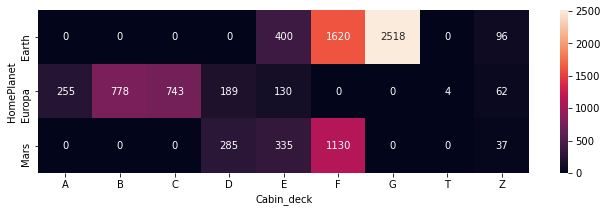

In [46]:
df_cabin_deck = train_new_features.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize = (11,3))
sns.heatmap(data=df_cabin_deck.T, annot=True, fmt='g')

What we learned:
- All passenger in 'CabinDeck':A, B, C, T come form 'Europa'
- All passenger in 'CabinDeck':G come form 'Earth'

Upcoming step:
- Impute 'HomePlanet' = 'Europa' if 'CabinDeck' is in ('A','B','C','T')
- Impute 'HomePlanet' = 'Earth' if 'CabinDeck' == 'G'

In [47]:
cabin_deck_to_planet = {"A": "Europa", "B": "Europa", "C": "Europa", "G": "Earth", "T": "Europa"}

def impute_homeplanet_europa_based_on_cabindeck(df, cabin_deck_to_planet):
    
    for cabin_deck, home_planet in cabin_deck_to_planet.items():
        df.loc[df['Cabin_deck'] == cabin_deck, 'HomePlanet'] = home_planet
    
    return df

In [48]:
train_new_features = impute_homeplanet_europa_based_on_cabindeck(train_new_features, cabin_deck_to_planet)
test_new_features = impute_homeplanet_europa_based_on_cabindeck(test_new_features, cabin_deck_to_planet)

In [49]:
# show number of missing values AFTER imputation
print("Train: Missing values in HomePlanet: ", train_new_features["HomePlanet"].isnull().sum())
print("Test: Missing values in HomePlanet: ", test_new_features["HomePlanet"].isnull().sum())

Train: Missing values in HomePlanet:  63
Test: Missing values in HomePlanet:  31


### Expenditure features X Age

The missing values in expenditure features(RoomService、Spa、VRDeck、FoodCourt、ShooppingMall) can be imputed based on 'AgeSubcategory'

<AxesSubplot:xlabel='AgeSubcategory', ylabel='have_expenses'>

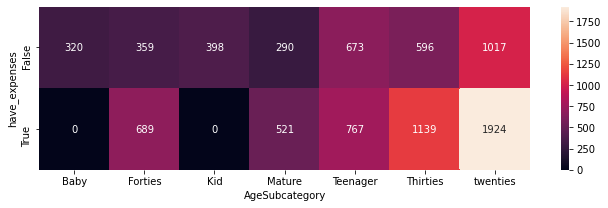

In [50]:
df_expense_age = train_new_features.groupby(['AgeSubcategory','have_expenses'])['have_expenses'].size().unstack().fillna(0)

plt.figure(figsize = (11,3))
sns.heatmap(data=df_expense_age.T, annot=True, fmt='g')

- Baby and Kid didn't spend money, so the missing vlaue in expenditure features of these two categories will be imputed 0

In [51]:
# show the missing values in expenditure features BEFORE imputation:

for expenses in expenditure_features:
    print(f'Train: Missing value in column {expenses}  : {train_new_features[expenses].isnull().sum()}')
    
for expenses in expenditure_features:
    print(f'Test: Missing value in column {expenses}  : {test_new_features[expenses].isnull().sum()}')

Train: Missing value in column RoomService  : 113
Train: Missing value in column FoodCourt  : 113
Train: Missing value in column ShoppingMall  : 112
Train: Missing value in column Spa  : 118
Train: Missing value in column VRDeck  : 126
Test: Missing value in column RoomService  : 57
Test: Missing value in column FoodCourt  : 67
Test: Missing value in column ShoppingMall  : 63
Test: Missing value in column Spa  : 59
Test: Missing value in column VRDeck  : 51


In [52]:
def impute_expenses_0_for_baby_kid(df, expenditure_features):
    
    for expenses in expenditure_features:
        df.loc[(df['AgeSubcategory'] == 'Baby') | (df['AgeSubcategory'] == 'Kid'), expenses] = 0
        
    return df

In [53]:
train_new_features = impute_expenses_0_for_baby_kid(train_new_features, expenditure_features)
test_new_features = impute_expenses_0_for_baby_kid(test_new_features, expenditure_features)

In [54]:
# show the missing values in expenditure features AFTER imputation:

for expenses in expenditure_features:
    print(f'Missing value in column {expenses} of training data : {train_new_features[expenses].isnull().sum()}')
    
for expenses in expenditure_features:
    print(f'Missing value in column {expenses} of testing data : {test_new_features[expenses].isnull().sum()}')

Missing value in column RoomService of training data : 108
Missing value in column FoodCourt of training data : 106
Missing value in column ShoppingMall of training data : 104
Missing value in column Spa of training data : 114
Missing value in column VRDeck of training data : 110
Missing value in column RoomService of testing data : 56
Missing value in column FoodCourt of testing data : 65
Missing value in column ShoppingMall of testing data : 61
Missing value in column Spa of testing data : 52
Missing value in column VRDeck of testing data : 44


### VIP X Age

<AxesSubplot:xlabel='AgeSubcategory', ylabel='VIP'>

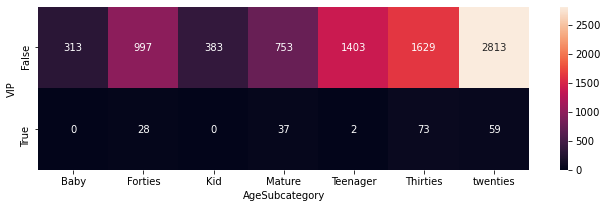

In [55]:
df_vip_age = train_new_features.groupby(['AgeSubcategory','VIP'])['VIP'].size().unstack().fillna(0)

plt.figure(figsize = (11,3))
sns.heatmap(data=df_vip_age.T, annot=True, fmt='g')

In [56]:
# show number of missing values BEFORE imputation
print("Train: Missing values in VIP: ", train_new_features["VIP"].isnull().sum())
print("Test: Missing values in VIP: ", test_new_features["VIP"].isnull().sum())

Train: Missing values in VIP:  203
Test: Missing values in VIP:  93


In [57]:
def impute_vip_false_if_baby_kid_teen(df):
    
    df.loc[(df['AgeSubcategory'] == 'Baby') | (df['AgeSubcategory'] == 'Kid'), 'VIP'] = False
    
    return df

In [58]:
train_new_features = impute_vip_false_if_baby_kid_teen(train_new_features)
test_new_features = impute_vip_false_if_baby_kid_teen(test_new_features)

In [59]:
# show number of missing values AFTER imputation
print("Train: Missing values in VIP: ", train_new_features["VIP"].isnull().sum())
print("Test: Missing values in VIP: ", test_new_features["VIP"].isnull().sum())

Train: Missing values in VIP:  181
Test: Missing values in VIP:  89


#### Impute all the individual expenses with 0 if total_expenses = 0

In [60]:
def impute_expense_0_if_totalexpenses_0(df, expenditure_features):
    
    for expenses in expenditure_features:
        
        df.loc[df['total_expenses'] == 0, expenses] = 0
        
    return df

In [61]:
train_new_features = impute_expense_0_if_totalexpenses_0(train_new_features, expenditure_features)
test_new_features = impute_expense_0_if_totalexpenses_0(test_new_features, expenditure_features)

In [62]:
# show the missing values in expenditure features AFTER imputation:
for expenses in expenditure_features:
    print(f'Missing value in column {expenses} of training data : {train_new_features[expenses].isnull().sum()}')
    
for expenses in expenditure_features:
    print(f'Missing value in column {expenses} of testing data : {test_new_features[expenses].isnull().sum()}')

Missing value in column RoomService of training data : 103
Missing value in column FoodCourt of training data : 102
Missing value in column ShoppingMall of training data : 100
Missing value in column Spa of training data : 112
Missing value in column VRDeck of training data : 102
Missing value in column RoomService of testing data : 53
Missing value in column FoodCourt of testing data : 65
Missing value in column ShoppingMall of testing data : 60
Missing value in column Spa of testing data : 50
Missing value in column VRDeck of testing data : 41


Update the exepnses group since some missing values are gone

In [63]:
train_new_features = create_expenses_group(train_new_features)
test_new_features = create_expenses_group(test_new_features)

### Missing values intermediary status

In [64]:
show_missing_value_percentage(train_new_features)

,Total,Percentage
luxury_expenses,311,3.71%
normal_expenses,201,2.37%
Name,200,2.35%
Destination,182,2.14%
VIP,181,2.13%
Spa,112,1.31%
RoomService,103,1.20%
FoodCourt,102,1.19%
VRDeck,102,1.19%
ShoppingMall,100,1.16%


In [65]:
show_missing_value_percentage(test_new_features)

,Total,Percentage
luxury_expenses,142,3.43%
normal_expenses,124,2.99%
Name,94,2.25%
Destination,92,2.20%
VIP,89,2.13%
FoodCourt,65,1.54%
ShoppingMall,60,1.42%
RoomService,53,1.25%
Spa,50,1.18%
VRDeck,41,0.97%


### Impute the continuous features with median

In [66]:
continues_features =  train_new_features.select_dtypes('float64').columns.drop(['normal_expenses', 'luxury_expenses'])

In [67]:
def impute_continus_features_median(df, continues_features):
    
    imputator = SimpleImputer(strategy='median')
    
    for features in continues_features:
        df[features]  = imputator.fit_transform(df[[features]])
        
    return df

In [68]:
train_new_features = impute_continus_features_median(train_new_features, continues_features)
test_new_features = impute_continus_features_median(test_new_features, continues_features)

In [69]:
# update the expenses_group to fill the NAs
train_new_features = create_expenses_group(train_new_features)
test_new_features = create_expenses_group(test_new_features)

### Impute the categorical features which remaining have miss values

In [70]:
remain_cat_features = train_new_features.columns[train_new_features.isna().any()]
print(remain_cat_features)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name'], dtype='object')


In [71]:
def impute_categorical_features(df, remain_cat_features):
    
    df[remain_cat_features] = df[remain_cat_features].fillna(df[remain_cat_features].mode().iloc[0])
    
    return df

In [72]:
train_new_features = impute_categorical_features(train_new_features, remain_cat_features)
test_new_features = impute_categorical_features(test_new_features, remain_cat_features)

In [73]:
show_missing_value_percentage(train_new_features)

,Total,Percentage


In [74]:
show_missing_value_percentage(test_new_features)

,Total,Percentage


# Preprocessing

## Drop unwanted column

In [75]:
train_for_preprocessing = train_new_features.drop(['PassengerId','Cabin', 'Cabin_num','passenger_group_number','Name','Transported'],axis = 1)
y = train_new_features['Transported'].copy().astype(int)
test_for_preprocessing = test_new_features.drop(['Cabin','Cabin_num','passenger_group_number','Name'],axis = 1)

## Log transform

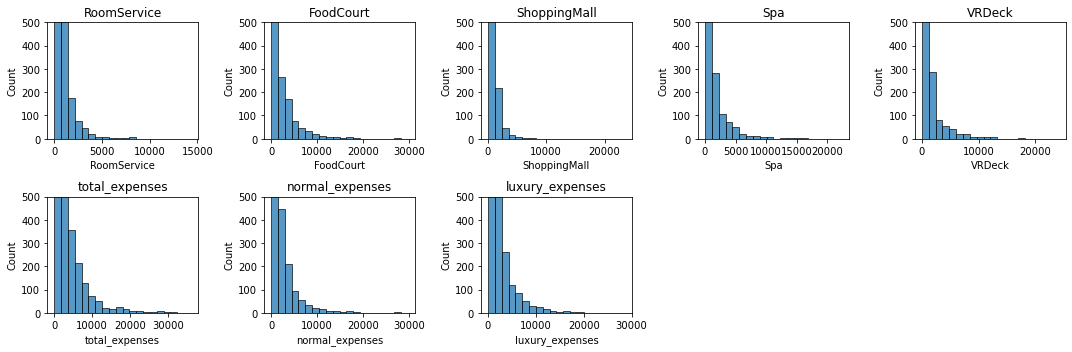

In [76]:
# show the distribution of continues features 
numerical_features = train_for_preprocessing.select_dtypes('float').columns.drop('Age')
fig = plt.figure(figsize=(15,5))

for idx, val in enumerate(numerical_features):
    ax = fig.add_subplot(2,5,idx+1)
    sns.histplot(data=train_for_preprocessing, x=val, axes=ax, bins=20)
    ax.set_title(val)
    
    plt.ylim([0,500])
    
plt.tight_layout()  
plt.show()

All the numerical features except Age will be log transformed

In [77]:
# log transform

for col in numerical_features:
    train_for_preprocessing[col] = np.log(1 + train_for_preprocessing[col])
    test_for_preprocessing[col] = np.log(1 + test_for_preprocessing[col])

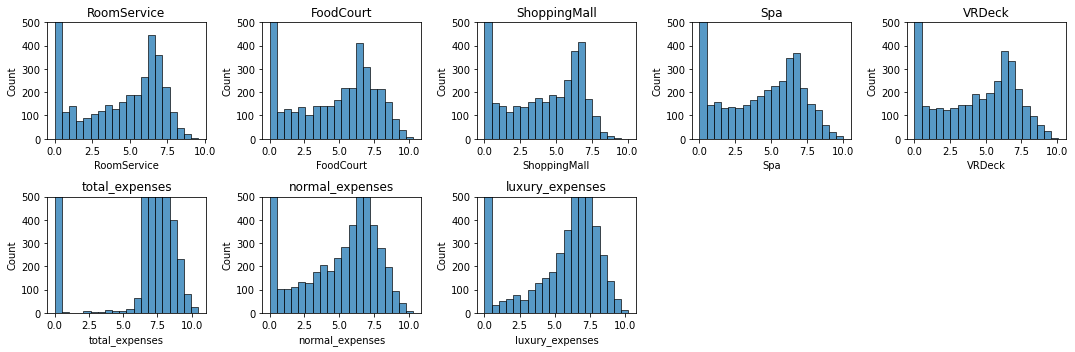

In [78]:
# check the result after log transform
fig = plt.figure(figsize=(15,5))

for idx, val in enumerate(numerical_features):
    ax = fig.add_subplot(2,5,idx+1)
    sns.histplot(data=train_for_preprocessing, x=val, axes=ax, bins=20)
    ax.set_title(val)
    
    plt.ylim([0,500])
    
plt.tight_layout()  
plt.show()

## Scaling & Encoding

- implement scaling on numerical features
- implement encoding(one-hot encoding) on categorical features

In [79]:
numerical_cols = [col for col in train_for_preprocessing.columns if train_for_preprocessing[col].dtypes in ['int64','float64']]
categorical_cols = [col for col in train_for_preprocessing.columns if train_for_preprocessing[col].dtypes in ['object'] and col != 'PassengerId']
bool_cols = [col for col in train_for_preprocessing.columns if 
            train_for_preprocessing[col].dtypes in ['bool'] or
            train_for_preprocessing[col].nunique() == 2
            ]

In [80]:
# scale numerical dtat to have mean = 0, variance = 1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# one-hot encode categorical data
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# label encode boolean data
boolean_transformer = Pipeline(steps=[('bool', OrdinalEncoder())])

# combine the transformers
preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bool', boolean_transformer, bool_cols)
    ],
    remainder='passthrough'
)

train_transformed = preprocessing.fit_transform(train_for_preprocessing)
test_transformed = preprocessing.transform(test_for_preprocessing)

# get the names of the one-hot encoded columns
feature_names = preprocessing.get_feature_names_out()

transformed_train_df = pd.DataFrame(train_transformed, columns=feature_names)
transformed_test_df = pd.DataFrame(test_transformed, columns=feature_names)

In [81]:
x_train, x_valid, y_train, y_valid = train_test_split(transformed_train_df, y, test_size=0.3, random_state=0)

# Training

Several models are compared and the best one is selected based on the performance.

Briefly describe the models:

**Logistic Regression**:
This model uses Maximum Likelihood Estimation to fit a Sigmoid function on the target variable distribution. This is commonly uses in classification problems.

**Random Froest(RF)**:
This is an ensemble of decision trees, and the trees are constrcuted by bootstrap sampling. Each tree will generate a prediction, and the final prediction determined by majority votes in classification problem.

**Extreme Gradient Boosting(XGBoost)**:
This model is also an ensemble model, but the way of deriving trees is different with RF. It is constructed by several simple models sequentially, and each tree is trained to correct the errors made by the previous tree. Moreover, XGBoost uses a technique called "gradient boosting" to optimize the result.

**​Light Gradient Boosting Machine (LGBM)**: 
LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

In [82]:
RANDOM_STATE = 6

In [83]:
classifiers_dict = {
    'LR' : LogisticRegression(solver='liblinear' ,random_state=RANDOM_STATE),
    'RF' : RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBC' : XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False),
    'LGBM' : LGBMClassifier(random_state=RANDOM_STATE),
    
    
}
classifiers_dict

{'LR': LogisticRegression(random_state=6, solver='liblinear'),
 'RF': RandomForestClassifier(random_state=6),
 'XGBC': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=6,
               reg_alpha=None, reg_lambda=None, ...),
 'LGBM': LGBMClassifier(random_state=6)}

In [84]:
# grids for GridSearchCV
LR_grid = {
    "penalty": ["l1","l2"],
    "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    "max_iter": [50, 100, 150]
}

RF_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [1, 2, 5, 10],
    'max_features': [10, 20, 25, 50]
}

XGBC_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [1, 2, 5, 10, 15],
    "colsample_bytree": [0.5, 1.0],
    "gamma": [0.5, 1.0],
    "subsample": [0.5, 1.0]
    
}

LGBM_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [1, 2, 5, 10, 15],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'feature_fraction' : [0.2, 0.5, 1.0]
}



In [85]:
grid_set = {
    'LR' : LR_grid,
    'RF' : RF_grid,
    'XGBC' : XGBC_grid,
    'LGBM' : LGBM_grid
}

In [86]:
classifier_training_scores = {}
i = 0

for key, classifier in classifiers_dict.items():
    
    # Grid serach the parameter
    clf = GridSearchCV(estimator=classifier, param_grid = grid_set[key], n_jobs=-1, cv=None)
    
    # train 
    clf.fit(x_train, y_train)
    
    # scoring(by default, scoring = accuracy_score for classification)
    clf.score(x_train, y_train)
    
    
    
    print('Model', key)
    print(clf.best_score_)
    print(clf.best_params_)
    
    
    classifier_training_scores[i] ={
        'classifier': key,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    }
    
    
    i += 1

Model LR
0.7945768282662284
{'C': 0.25, 'max_iter': 50, 'penalty': 'l1'}
Model RF
0.7988496302382908
{'max_depth': 10, 'max_features': 10, 'n_estimators': 200}
Model XGBC
0.8036154478225145
{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Model LGBM
0.8059161873459326
{'feature_fraction': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [144]:
pd.DataFrame(classifier_training_scores).transpose().sort_values('best_score', ascending= False)

,classifier,best_score,best_params
3,LGBM,0.805588,"{'feature_fraction': 1.0, 'learning_rate': 0.0..."
2,XGBC,0.803615,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_d..."
1,RF,0.798685,"{'max_depth': 10, 'max_features': 10, 'n_estim..."
0,LR,0.794577,"{'C': 0.25, 'max_iter': 50, 'penalty': 'l1'}"


In [96]:
# best model and hyperparamter
final_model = LGBMClassifier(**classifier_training_scores[3]['best_params'], random_state=RANDOM_STATE)


# Prediction

In [101]:
final_model.fit(x_train, y_train)
final_model.predict_proba(transformed_test_df)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


array([[2.95376161e-01, 7.04623839e-01],
       [9.97566814e-01, 2.43318572e-03],
       [8.30119647e-04, 9.99169880e-01],
       ...,
       [2.77057224e-02, 9.72294278e-01],
       [9.05837095e-02, 9.09416290e-01],
       [3.05814693e-01, 6.94185307e-01]])